In [217]:
import pandas as pd
import redis
from matplotlib import pyplot as plt
import timeit

Let's first store our training dataset in our Redis database for easy access. For this project, we'll be using the `jigsaw-toxic-comment-classification-challenge` dataset to train our NLP model in classifying toxic comments. 

You **must** first download the training dataset and extract the archive in the `data/` sub-directory of this project.

In [218]:
# Let's first do a small EDA of our training data
train_df = pd.read_csv("data/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [219]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Our dataset contains ~160k entries. The training dataset also comes with a testing dataset in `data/test.csv` as well as the classification results in `data/test_labels.csv`.

<Axes: >

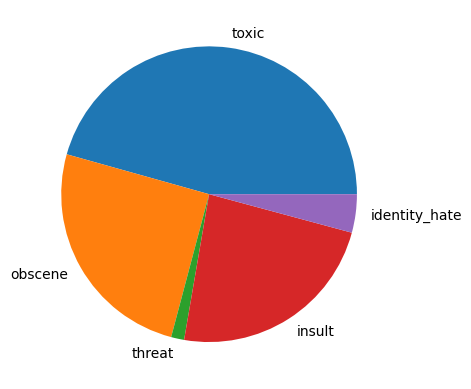

In [220]:
train_df[['toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='pie')

Above you see the overall distribution of toxic comments. We'll be doing multi-label classification using NLP on those comments.

In [221]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Redis is meant to be used in multiple ways and is basically a large-scale, distributed and high-performance key-value datastore. It also supports indexing and storage of JSON document, which we'll be using here to store both our **training** and **testing** datasets.

In [222]:
# connect to local redis database
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

Let's make sure the database is filled up and ready to go by checking the dbsize(). 

**If the number printed below is zero, make sure you ran the `python ./fill_db.py` command. Prior to executing this notebook**.

In [223]:
# checking to make sure every entries was inserted into database
r.dbsize()

312735

Now that we have the training and testing dataset into our Redis database, we'll define our neural network.

We'll make sure of the `torchtext` python package which provides an out-of-the-box sentence tokenizer as well as the GloVe embedding. For this project, we decided to use the GloVe 840B embeddings of 300 dimensions for each words. Below we initialize both the tokenizer and the glove embeddings, running this cell might take some as it needs to fetch the embeddings remotely.

In [224]:
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(name='840B', dim=300)

We'll write our own torch `Dataset` and `DataLoader` definition to be used in conjunction with Pytorch. More specifically, this dataset and dataloader are going to query the Redis database to return both our testing and training data in real-time.

The dataset takes care of returning elements in our database one-by-one in an iterator fashion. 
The dataloader takes in the `collate_fn` as a parameter which `vectorize_batch` is passed in in order to encode the comment text into GloVe embeddings.

This way, Redis can act as the backend database for training the neural network using real time data.

In [253]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.functional import to_map_style_dataset
import sys

MAX_COMMENT_LENGTH = 50
EMBED_LEN = 300
NORMAL_CLASS = "normal"
TARGET_CLASSES = [NORMAL_CLASS, "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test = 0
def get_target_class(obj, idx):
    obj[NORMAL_CLASS] = 0
    labels = {attr: obj[attr] for attr in TARGET_CLASSES}
    ret = next((k for k, v in labels.items() if v == 1), None)
    return NORMAL_CLASS if ret is None else ret

class RedisDataset(Dataset):
    def __init__(self, redis, redis_key_prefix):
        self.redis = redis
        self.scan_iter = self.redis.scan_iter(redis_key_prefix + "*")
        self.length = len(self.redis.keys(redis_key_prefix + "*"))
        self.curr_idx = 0
        self.redis_key_prefix = redis_key_prefix

    def __len__(self):
        return self.length - 1
        
    def __getitem__(self, idx):
        key = self.redis_key_prefix + "%d" % idx
        print(key, end='\r')
        obj = r.json().get(key)
        if obj is None:
            print("", end='\n')
            raise IndexError()
        label = get_target_class(obj, key)
        return obj["comment_text"], TARGET_CLASSES.index(label)

In [254]:
train_dataset, test_dataset = RedisDataset(r, "train:"), RedisDataset(r, "test:")
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train:159571
test:153164


We not create the pytorch DataLoader for our custom Redis-backed dataset. The `vectorize_batch` function takes care of tokenzing and embedding the `comment_text` into the GloVe embeddings up to a `MAX_LENGTH` and pads it with empty string to fit the length of 0 in the case where the comment text is too short. 

In [226]:
def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (MAX_COMMENT_LENGTH-len(tokens)) if len(tokens) < MAX_COMMENT_LENGTH else tokens[:MAX_COMMENT_LENGTH] for tokens in X]
    X_tensor = torch.zeros(len(batch), MAX_COMMENT_LENGTH, EMBED_LEN)
    for i, tokens in enumerate(X):
        X_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    return X_tensor.reshape(len(batch), -1), torch.tensor(Y)

train_loader, test_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch), DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch)
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 15000]) torch.Size([1024])


Below we define our `ToxicCommentClassifier` which is a simple Pytorch neural network. It consists of 4 linear layers of 256, 128, 64 and 7 output units. We use the ReLU activation function after each layer.

In [227]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

class ToxicCommentClassifier(nn.Module):
    def __init__(self):
        super(ToxicCommentClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(MAX_COMMENT_LENGTH*EMBED_LEN, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, len(TARGET_CLASSES))
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [228]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))
        
losses_graph = []
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader): # for each batch
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses_graph.append(torch.tensor(losses).mean())
        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [229]:
from torch.optim import Adam

epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = ToxicCommentClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]


Train Loss : 0.093
Valid Loss : 0.112
Valid Acc  : 0.964


100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:32<00:00,  4.75it/s]


Train Loss : 0.051
Valid Loss : 0.065
Valid Acc  : 0.976


100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]


Train Loss : 0.023
Valid Loss : 0.077
Valid Acc  : 0.975


100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]


Train Loss : 0.013
Valid Loss : 0.013
Valid Acc  : 0.996


100%|█████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.68it/s]


Train Loss : 0.006
Valid Loss : 0.019
Valid Acc  : 0.994


In [230]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9942032073497064

Confusion Matrix : 
[[143295     45      2      0      4      0]
 [   830  14449      8      1      6      0]
 [     9      3    511      0      0      0]
 [     3      1      0     19      2      0]
 [     5      4      0      0    320      0]
 [     0      1      0      0      1     52]]


In [231]:
def do_prediction(model, text):
    text_tokens = tokenizer(text)
    text_tokens = text_tokens[:MAX_COMMENT_LENGTH]
    X_tensor = torch.zeros(1, MAX_COMMENT_LENGTH, EMBED_LEN)
    if len(text_tokens) < MAX_COMMENT_LENGTH:
        text_tokens = text_tokens + ([""] * (MAX_COMMENT_LENGTH - len(text_tokens)))
    X_tensor[0] = global_vectors.get_vecs_by_tokens(text_tokens)
    preds = model(X_tensor.reshape(1, -1))
    
    return TARGET_CLASSES[(preds.argmax(dim=-1).detach().numpy())[0]]

print("Predicting sentence `this project was great`:", do_prediction(embed_classifier, "this project was great!"))
print("Predicting sentence `you are so bad you cant finish this project`:", do_prediction(embed_classifier, "you are so bad you cant finish this project"))

Predicting sentence `this project was great`: normal
Predicting sentence `you are so bad you cant finish this project`: normal


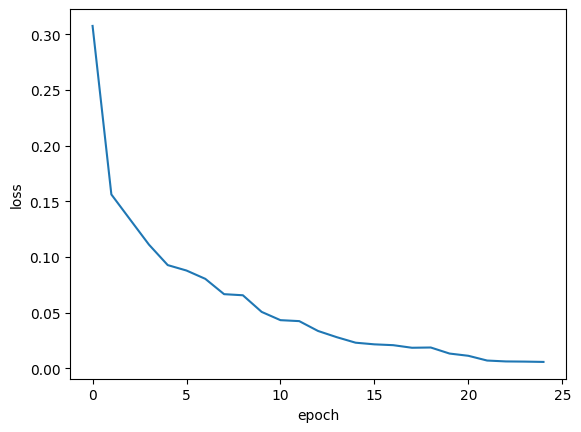

In [232]:
import matplotlib.pyplot as plt
losses = list(map(lambda t: t.detach().item(), losses_graph))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

Now we can use the same `RedisDataset` to process unlabeled data in conjunction with Pytorch's DataLoader, similar to what we have done above for training and testing the model. Predictions are going to be stored at the same key for which it was returned.

Each entry in the `unlabeled:` index will be retrieved, passed through the model, and moved to the `label:*` index with its prediction.

In [311]:
from redis.commands.json.path import Path
test_example_0 = {
    'id': "jepoisso-0",
    'comment_text': "i love this project",
    'toxic': 0,
    'severe_toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:0", Path.root_path(), test_example_0)

test_example_1 = {
    'id': "jepoisso-1",
    'comment_text': "you are dumb",
    'toxic': 0,
    'severe_toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:1", Path.root_path(), test_example_1)

from redis.commands.json.path import Path
test_example_2 = {
    'id': "jepoisso-2",
    'comment_text': "wow this is nice",
    'toxic': 0,
    'severe_toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:2", Path.root_path(), test_example_2)

from redis.commands.json.path import Path
test_example_3 = {
    'id': "jepoisso-3",
    'comment_text': "this is great",
    'toxic': 0,
    'severe_toxic': 0,
    'obscene': 0,
    'threat': 0,
    'insult': 0,
    'identity_hate': 0
}
r.json().set("unlabeled:3", Path.root_path(), test_example_3)

True

In [312]:
last_idx = len(r.keys("labeled:*"))
def process_unlabeled(model, loader):
    for X, Y in loader:
        preds = model(X)
        predicted_labels = F.softmax(preds, dim=-1).argmax(dim=-1).detach().numpy()
        print("Predicted labels = ", list(map(lambda i: TARGET_CLASSES[i], predicted_labels)))

unlabeled_dataset = RedisDataset(r, "unlabeled:")
unlabeled_dataset = to_map_style_dataset(unlabeled_dataset)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=1, collate_fn=vectorize_batch)

process_unlabeled(embed_classifier, unlabeled_loader)

unlabeled:4
Predicted labels =  ['normal']
Predicted labels =  ['toxic']
Predicted labels =  ['normal']
Predicted labels =  ['normal']
